In [1]:
import os, sys
sys.path.append('../src')

from copulae1 import *
from KDEs import *
from toolbox import *
import json
np.random.seed(0)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
config_path = '../src/configs/config_future_brr_new_MM.json'
with open(config_path) as f:
	config = json.load(f)
# Data source
data_name = config['data_name']
data_path = "../processed_data/" + data_name + "/"
spot_name = config['spot_name']
future_name = config['future_name']

# Calibration Method
calibration_method = config['calibration_method']  # MM or MLE
if calibration_method =='MM':
	q_arr = config['q_arr']  # moment conditions for MM

# Load parameters
if calibration_method == "MLE":
	paras = pd.read_json("../results/" + data_name + "/MLE/parameters.json")
elif calibration_method == "MM":
	paras = pd.read_json("../results/" + data_name + "/MM/parameters.json")

# Path for reading OHR results and storing HE results
if calibration_method == 'MLE':
    result_path = "../results/"+data_name+"/MLE/"
elif calibration_method == 'MM':
    result_path = "../results/"+data_name+"/MM/"

In [3]:
file = '0.csv'


train = pd.read_csv(data_path + 'train/' + file)
spot = train.loc[:, spot_name]
future = train.loc[:, future_name]
u = ECDF(spot)(spot)
v = ECDF(future)(future)

kde_brr = KDE(spot, "Gaussian")
kde_btc = KDE(future, "Gaussian")

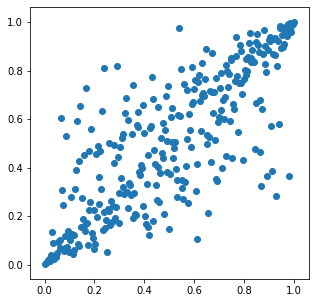

In [4]:
plt.figure(figsize=(5,5))
plt.scatter(u,v)

In [5]:
C1 = Gaussian(dict(rho=0.9),      
               Law_RS=kde_brr,
               Law_RF=kde_btc) # fix the maringals!

if calibration_method == "MLE":
    C1.canonical_calibrate(u, v)

elif calibration_method == "MM":
    C1.mm_calibrate(u, v, q_arr)

Optimization terminated successfully.
         Current function value: 0.055067
         Iterations: 31
         Function evaluations: 66


../src/copulae1.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m_hat = np.array([self.tau()] + [self._lambda(q) for q in q_arr])


In [6]:
C1.paras # compare with last column of  file:///Users/francis/Google%20Drive/00_IRTG1792/copula/results/future_brr_new/MM/paras.html

{'rho': 0.925409241244197}

In [7]:
k_arr = config["k_ERM"] # Absolute risk aversion for exponential risk measure
q_arr_ES = config["q_arr_ES"] # Quantile level for expected shortfall
q_arr_VaR = config["q_arr_VaR"] # Quantile level for Value at Risk

# OHR for variance, ERM, ES, VaR
optimize_h(C1, k_arr, q_arr_ES, q_arr_VaR)

Optimization terminated successfully.
         Current function value: 0.000435
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.033611
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.086215
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.053246
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.066192
         Iterations: 10
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: 0.031648
         Iterations: 13
         Function evaluations: 28


[0.9235351562499999,
 0.9256835937499998,
 1.0833007812500002,
 0.99365234375,
 0.9972656249999999,
 0.880859375]

In [8]:
btc = train.loc[:,'log return future']
brr = train.loc[:,'log return bitcoin']

0.8484848484848485


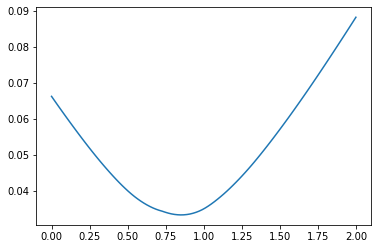

In [9]:
# train
h_arr = np.linspace(0,2,100)
ERM_arr_train = []

for h in h_arr:
    ERM_arr_train.append(ERM_estimate_trapezoidal(10, btc-h*brr))
plt.plot(h_arr, ERM_arr_train)
print(h_arr[np.argmin(ERM_arr_train)])

0.9292929292929294


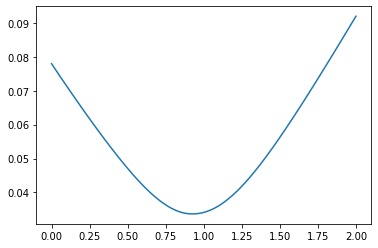

In [12]:
sample = C1.sample(1000000)
rs = sample[:, 0]
rf = sample[:, 1]

ERM_arr_sample = []

for h in h_arr:
    ERM_arr_sample.append(ERM_estimate_trapezoidal(10, rs-h*rf))
plt.plot(h_arr, ERM_arr_sample)
print(h_arr[np.argmin(ERM_arr_sample)])

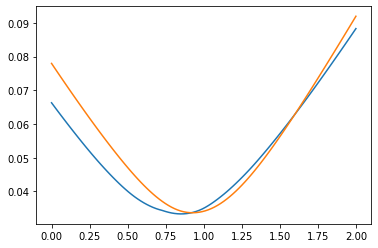

In [13]:
plt.plot(h_arr, ERM_arr_train)
plt.plot(h_arr, ERM_arr_sample)